In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pltio
from scipy.stats import ttest_ind

In [8]:
def data_analysis_procedure(data_df):
    print("Starting data analysis...")
    #print(daily_augmented.head())
    
    # Calc rolling mean with window m
    m=15
    qty_roll_median = data_df.qty.rolling(window=m).median()
    median_first_m = np.median(data_df.iloc[:15, 0])
    full_roll_median = qty_roll_median.fillna(median_first_m)

    # Add signals for rolling mean and compatibility of phenomena
    new_signal_vals = [1 if val > full_roll_median[idx] else -1 for idx, val in enumerate(data_df.qty.values)]
    data_df["rolling_medianlbl"] = new_signal_vals

    # Calc annual means
    data_df["yearly_median"] = np.zeros(data_df.shape[0])
    yearly_range = range(min(data_df.index.year), max(data_df.index.year)+1)
    for i in yearly_range:
        median = data_df.loc[str(i)].qty.median()
        data_df.loc[str(i), "yearly_median"] = median

    # Add a singal of months and calculate monthly means
    data_df["month"] = data_df.index.month
    monthly_medians = data_df.qty.resample("M").median()    
    data_df["monthly_median"] = [monthly_medians.loc[str(daily_idx.year)+"-"+str(daily_idx.month)].values[0] for daily_idx in data_df.index]

    # Yearly mean lbl
    data_df["ymedian_lbl"] = [1 if val > data_df["yearly_median"][idx] else -1 for idx, val in enumerate(data_df.qty.values)]

    print("Added rolling, yearly and monthly median signals, needed for statistical analysis.")
    print("Beginning plots and tests.\n")
    #print(data_df.head())
    
    # Day of the week analysis
    plt.figure(figsize=(14,8))
    plt.title("Sales through time in different days of the week")
    ax = sns.scatterplot(x=range(0, len(data_df)), y="qty", hue="day_of_week", palette="Set3",\
                         size="day_of_week", sizes=(60, 180), legend="full", data=data_df)
    ax.set(xlabel="Time steps")
    plt.show()
    
    dow_ctg_matrix = pd.crosstab(data_df["rolling_medianlbl"], data_df["day_of_week"])
    print(dow_ctg_matrix, "\n")
    print("Running Chi-Square test...")
    print(chi2_contingency(dow_ctg_matrix))
    
    # Month of the year analysis (holiday seasons)
    plt.figure(figsize=(14,8))
    plt.plot(data_df.qty, label="Sales data")
    plt.plot(qty_roll_median, label="Rolling median with window "+str(m)) 
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(16,8))
    plt.title("Sales through time in different months ")
    plt.plot(range(0, len(data_df)), data_df.yearly_median.values, label="yearly median")
    ax = sns.scatterplot(x=range(0, len(data_df)), y="qty", hue="month", palette="tab20", size="month", sizes=(60, 100),\
                         legend="full", data=data_df)
    ax.set(xlabel="Time steps")
    plt.show()
    
    # Build a contingency table for the sales by months and the annual mean
    moy_ctg_matrix = pd.crosstab(data_df["ymedian_lbl"], data_df["month"])
    print(moy_ctg_matrix, "\n")
    print("Running Chi-Square test...")
    print(chi2_contingency(moy_ctg_matrix))
    
    # Rainy or non rainy weather analysis
    weather_totals = data_df.groupby(pd.Grouper("conditions")).agg({
        "qty": np.mean
    })
    weather_totals["counts"] = data_df.conditions.value_counts()
    weather_totals.columns = ["mean_qty", "counts"]
    weather_totals.sort_values(by="mean_qty", ascending=False, inplace=True)
    print("\nMean sales when the weather is rainy (-1) and when it is not (1) for the whole year:")
    print(weather_totals)
    
    no_sales_data_df = data_df.copy(deep=True)
    no_sales_data_df = no_sales_data_df.drop(no_sales_data_df[no_sales_data_df.index.month.isin([1, 2, 7, 8, 12])].index, axis=0)    
    weather_totals_nosales = no_sales_data_df.groupby(pd.Grouper("conditions")).agg({
        "qty": np.mean
    })
    weather_totals_nosales["counts"] = no_sales_data_df.conditions.value_counts()
    weather_totals_nosales.columns = ["mean_qty", "counts"]
    weather_totals_nosales.sort_values(by="mean_qty", ascending=False, inplace=True)
    print("\nMean sales when the weather is rainy (-1) and when it is not (1) without sale seasons:")
    print(weather_totals_nosales)
    print()

In [9]:
# Sales data for all shopping centers
rome_neg_rmnaz_data = pd.read_csv("../../datasets/ts_data/newdaily/daily_aug/aug_rome_neg_rmnaz_data.csv", index_col=[0], parse_dates=True)
rome_neg_tusc1_data = pd.read_csv("../../datasets/ts_data/newdaily/daily_aug/aug_rome_neg_tusc1_data.csv", index_col=[0], parse_dates=True)
rome_neg_tusc2_data = pd.read_csv("../../datasets/ts_data/newdaily/daily_aug/aug_rome_neg_tusc2_data.csv", index_col=[0], parse_dates=True)
rome_neg_tibur_data = pd.read_csv("../../datasets/ts_data/newdaily/daily_aug/aug_rome_neg_tibur_data.csv", index_col=[0], parse_dates=True)

In [10]:
all_shops = pd.concat(
    [rome_neg_rmnaz_data, rome_neg_tusc1_data, rome_neg_tusc2_data, rome_neg_tibur_data], 
    axis=0)
all_shops.sort_index(inplace=True)
all_shops

,qty,sin_day,cos_day,sincos_day,day_of_week,TMEDIA °C,TMIN °C,TMAX °C,PUNTORUGIADA °C,UMIDITA %,VISIBILITA km,VENTOMEDIA km/h,VENTOMAX km/h,RAFFICA km/h,PRESSIONESLM mb,conditions
time,,,,,,,,,,,,,,,,
2016-01-02,49,3.442161e-02,0.999407,3.440121e-02,5,11.0,8.0,13.0,8.0,80.0,7.0,16.0,28.0,48.0,1018.0,-1
2016-01-02,18,3.442161e-02,0.999407,3.440121e-02,5,11.0,8.0,13.0,8.0,80.0,7.0,16.0,28.0,48.0,1018.0,-1
2016-01-02,43,3.442161e-02,0.999407,3.440121e-02,5,11.0,8.0,13.0,8.0,80.0,7.0,16.0,28.0,48.0,1018.0,-1
2016-01-03,34,5.161967e-02,0.998667,5.155085e-02,6,11.0,8.0,13.0,8.0,80.0,7.0,16.0,28.0,48.0,1018.0,1
2016-01-03,35,5.161967e-02,0.998667,5.155085e-02,6,11.0,8.0,13.0,8.0,80.0,7.0,16.0,28.0,48.0,1018.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-30,110,-1.721336e-02,0.999852,-1.721081e-02,0,5.0,1.0,10.0,0.0,53.0,20.0,13.0,22.0,0.0,1029.0,1
2019-12-31,44,-2.449294e-16,1.000000,-2.449294e-16,1,4.0,-1.0,10.0,0.0,59.0,20.0,7.0,13.0,0.0,1030.0,1
2019-12-31,109,-2.449294e-16,1.000000,-2.449294e-16,1,4.0,-1.0,10.0,0.0,59.0,20.0,7.0,13.0,0.0,1030.0,1


Starting data analysis...
Added rolling, yearly and monthly median signals, needed for statistical analysis.
Beginning plots and tests.



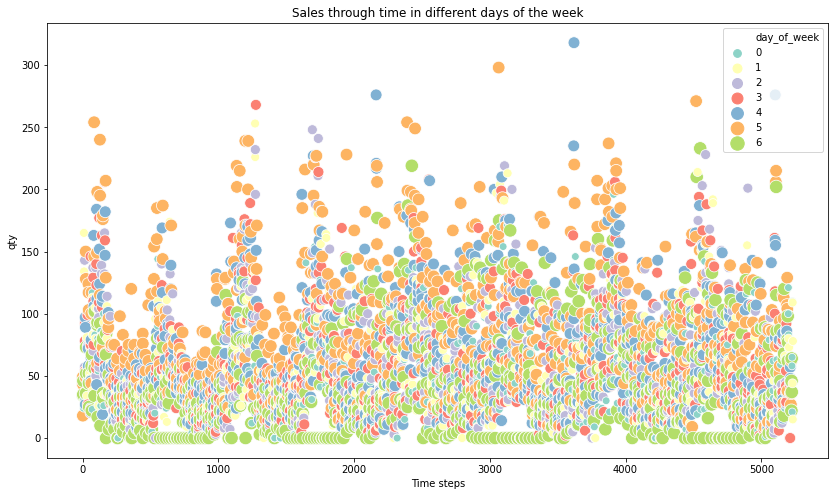

day_of_week          0    1    2    3    4    5    6
rolling_medianlbl                                   
-1                 544  448  351  316  327  223  582
 1                 205  301  395  430  419  526  167 

Running Chi-Square test...
(545.4335822275721, 1.362012764882648e-114, 6, array([[399.39988536, 399.39988536, 397.80015285, 397.80015285,
        397.80015285, 399.39988536, 399.39988536],
       [349.60011464, 349.60011464, 348.19984715, 348.19984715,
        348.19984715, 349.60011464, 349.60011464]]))


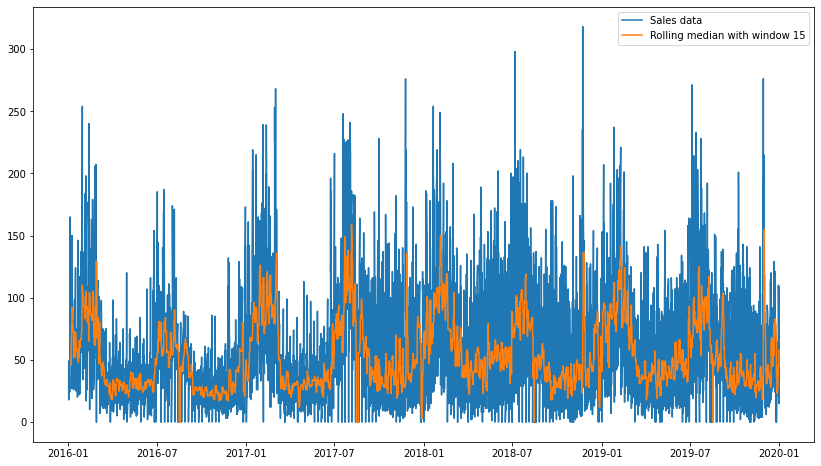

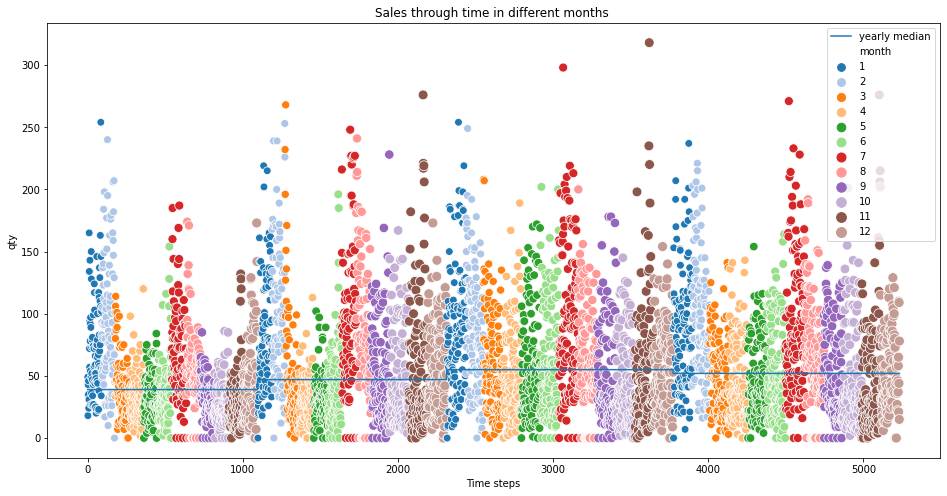

month         1    2    3    4    5    6    7    8    9    10   11   12
ymedian_lbl                                                            
-1           123   75  244  293  289  237  104  155  278  319  280  237
 1           308  320  190  127  145  183  330  281  172  146  170  228 

Running Chi-Square test...
(628.7210140526357, 1.0017910498895334e-127, 11, array([[216.89988536, 198.78295759, 218.40962935, 211.36415743,
        218.40962935, 211.36415743, 218.40962935, 219.41612533,
        226.46159725, 234.01031716, 226.46159725, 234.01031716],
       [214.10011464, 196.21704241, 215.59037065, 208.63584257,
        215.59037065, 208.63584257, 215.59037065, 216.58387467,
        223.53840275, 230.98968284, 223.53840275, 230.98968284]]))

Mean sales when the weather is rainy (-1) and when it is not (1) for the whole year:
             mean_qty  counts
conditions                   
 1          61.533235    3400
-1          55.549618    1834

Mean sales when the weather is rainy (-

In [11]:
data_analysis_procedure(all_shops)

In [14]:
no_sales_data_df = all_shops.copy(deep=True)
np.random.seed(21)

years_in_df = no_sales_data_df.index.year.unique().tolist()
spring_summer = [3,4,5,6]
autumn_winter = [9,10,11,12]
for year in years_in_df:
    yearly_data = no_sales_data_df.loc[str(year)]

    first_season = yearly_data[yearly_data.index.month.isin(spring_summer)]
    
    first_workday = first_season[(first_season.index.dayofweek == 0) | (first_season.index.dayofweek == 1) | \
                             (first_season.index.dayofweek == 2) | (first_season.index.dayofweek == 3)]
   
    ## resampling
    first_rainy_work = first_workday[first_workday.conditions == -1].qty
    first_non_rainy_work = first_workday[first_workday.conditions == 1].qty
    if(len(first_rainy_work) > len(first_non_rainy_work)):
        first_rainy_work = first_rainy_work[:len(first_non_rainy_work)]
    else:
        first_non_rainy_work = first_non_rainy_work[:len(first_rainy_work)]

    print("spring-summer sales", year, "on work days")
    print("Non rainy #:", len(first_non_rainy_work), "Rainy #:", len(first_rainy_work))
    print("Non rainy mean:", np.mean(first_non_rainy_work), "Rainy mean:", np.mean(first_rainy_work))
    print("Non rainy var:", np.std(first_non_rainy_work)**2, "Rainy var:", np.std(first_rainy_work)**2)
    first_rainy_work_var = np.std(first_rainy_work)**2
    first_non_rainy_work_var = np.std(first_non_rainy_work)**2
    if(first_rainy_work_var > 2*first_non_rainy_work_var or first_non_rainy_work_var > 2*first_rainy_work_var):
        print("Welch", ttest_ind(first_non_rainy_work, first_rainy_work, equal_var=False))
    else:
        print("Student's", ttest_ind(first_non_rainy_work, first_rainy_work, equal_var=True))

    print()
    
    first_offday = first_season[(first_season.index.dayofweek == 4) | (first_season.index.dayofweek == 5) | \
                             (first_season.index.dayofweek == 6)]

    first_rainy_off = first_offday[first_offday.conditions == -1].qty
    first_non_rainy_off = first_offday[first_offday.conditions == 1].qty
    if(len(first_rainy_off) > len(first_non_rainy_off)):
        first_rainy_off = first_rainy_off[:len(first_non_rainy_off)]
    else:
        first_non_rainy_off = first_non_rainy_off[:len(first_rainy_off)]
        
    print("spring-summer sales", year, "on off days")
    print("Non rainy #:", len(first_non_rainy_off), "Rainy #:", len(first_rainy_off))
    print("Non rainy mean:", np.mean(first_non_rainy_off), "Rainy mean:", np.mean(first_rainy_off))
    print("Non rainy var:", np.std(first_non_rainy_off)**2, "Rainy var:", np.std(first_rainy_off)**2)
    first_rainy_off_var = np.std(first_rainy_off)**2
    first_non_rainy_off_var = np.std(first_non_rainy_off)**2
    if(first_rainy_off_var > 2*first_non_rainy_off_var or first_non_rainy_off_var > 2*first_rainy_off_var):
        print("Welch", ttest_ind(first_non_rainy_off, first_rainy_off, equal_var=False))
    else:
        print("Student's", ttest_ind(first_non_rainy_off, first_rainy_off, equal_var=True))
    print()
    
    ##########################################################################################################
    
    second_season = yearly_data[yearly_data.index.month.isin(autumn_winter)]
    
    second_workday = second_season[(second_season.index.dayofweek == 0) | (second_season.index.dayofweek == 1) | \
                             (second_season.index.dayofweek == 2) | (second_season.index.dayofweek == 3)]
    
    second_rainy_work = second_workday[second_workday.conditions == -1].qty
    second_non_rainy_work = second_workday[second_workday.conditions == 1].qty
    if(len(second_rainy_work) > len(second_non_rainy_work)):
        second_rainy_work = second_rainy_work[:len(second_non_rainy_work)]
    else:
        second_non_rainy_work = second_non_rainy_work[:len(second_rainy_work)]

    print("Welch T-test comparing autumn-winter sales", year, "on work days")
    print("Non rainy #:", len(second_non_rainy_work), "Rainy #:", len(second_rainy_work))
    print("Non rainy mean:", np.mean(second_non_rainy_work), "Rainy mean:", np.mean(second_rainy_work))
    print("Non rainy var:", np.std(second_non_rainy_work)**2, "Rainy var:", np.std(second_rainy_work)**2)
    second_rainy_work_var = np.std(second_rainy_work)**2
    second_non_rainy_work_var = np.std(second_non_rainy_work)**2
    if(second_rainy_work_var > 2*second_non_rainy_work_var or second_non_rainy_work_var > 2*second_rainy_work_var):
        print("Welch", ttest_ind(second_non_rainy_work, second_rainy_work, equal_var=False))
    else:
        print("Student's", ttest_ind(second_non_rainy_work, second_rainy_work, equal_var=True))
    print()
    
    second_offday = second_season[(second_season.index.dayofweek == 4) | (second_season.index.dayofweek == 5) | \
                            (second_season.index.dayofweek == 6)]
  
    second_rainy_off = second_offday[second_offday.conditions == -1].qty
    second_non_rainy_off = second_offday[second_offday.conditions == 1].qty
    if(len(second_rainy_off) > len(second_non_rainy_off)):
        second_rainy_off = second_rainy_off[:len(second_non_rainy_off)]
    else:
        second_non_rainy_off = second_non_rainy_off[:len(second_rainy_off)]


    print("Welch T-test comparing autumn-winter sales", year, "on off days")
    print("Non rainy #:", len(second_non_rainy_off), "Rainy #:", len(second_rainy_off))
    print("Non rainy mean:", np.mean(second_non_rainy_off), "Rainy mean:", np.mean(second_rainy_off))
    print("Non rainy var:", np.std(second_non_rainy_off)**2, "Rainy var:", np.std(second_rainy_off)**2)
    second_rainy_off_var = np.std(second_rainy_off)**2
    second_non_rainy_off_var = np.std(second_non_rainy_off)**2
    if(second_rainy_off_var > 2*second_non_rainy_off_var or second_non_rainy_off_var > 2*second_rainy_off_var):
        print("Welch", ttest_ind(second_non_rainy_off, second_rainy_off, equal_var=False))
    else:
        print("Student's", ttest_ind(second_non_rainy_off, second_rainy_off, equal_var=True))
    print()
    
    print("\n\n\n")


spring-summer sales 2016 on work days
Non rainy #: 84 Rainy #: 84
Non rainy mean: 34.404761904761905 Rainy mean: 29.035714285714285
Non rainy var: 403.5504535147393 Rainy var: 315.4392006802721
Student's Ttest_indResult(statistic=1.824210627025261, pvalue=0.06991836525688618)

spring-summer sales 2016 on off days
Non rainy #: 45 Rainy #: 45
Non rainy mean: 38.577777777777776 Rainy mean: 36.422222222222224
Non rainy var: 586.6883950617282 Rainy var: 715.2217283950617
Student's Ttest_indResult(statistic=0.39627352371946123, pvalue=0.692862501352193)

Welch T-test comparing autumn-winter sales 2016 on work days
Non rainy #: 75 Rainy #: 75
Non rainy mean: 25.053333333333335 Rainy mean: 27.506666666666668
Non rainy var: 133.19715555555553 Rainy var: 241.4766222222222
Student's Ttest_indResult(statistic=-1.090299391857969, pvalue=0.2773532454354684)

Welch T-test comparing autumn-winter sales 2016 on off days
Non rainy #: 75 Rainy #: 75
Non rainy mean: 46.44 Rainy mean: 33.46666666666667
Non